<a href="https://colab.research.google.com/github/TriannaHappy/WeatherForecastwithLSTM/blob/main/LSTM_for_WeatherForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [33]:
import pandas as pd
from pylab import *
import numpy as np
import glob
import warnings
import datetime
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from scipy.stats import stats, skew, pearsonr

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, Dropout, Bidirectional
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

# Data Loading

In [34]:
pathpath='/content/drive/MyDrive/Data/bmkg data'
Bandung=pd.read_excel(pathpath+'/scrap/Stasiun Geofisika Bandung 2000-2024_scrap.xlsx')
Bandung_met=Bandung.iloc[8:-16,:]
Bandung_met.columns=Bandung.iloc[7]
Bandung_met.reset_index(drop=True, inplace=True)

for column in Bandung_met.columns[1:-1]:
    Bandung_met[column]=pd.to_numeric(Bandung_met[column])
    Bandung_met[column].replace(8888, np.nan, inplace=True)
    Bandung_met[column].replace(9999, np.nan, inplace=True)

Bandung_met=Bandung_met[:-3]

Bandung_met['Tanggal']=pd.to_datetime(Bandung_met['Tanggal'], format='%d-%m-%Y')
Bandung_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8861 entries, 0 to 8860
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  8861 non-null   datetime64[ns]
 1   Tn       8474 non-null   float64       
 2   Tx       8531 non-null   float64       
 3   Tavg     8702 non-null   float64       
 4   RH_avg   8557 non-null   float64       
 5   RR       7565 non-null   float64       
 6   ss       8458 non-null   float64       
 7   ff_x     8742 non-null   float64       
 8   ddd_x    8732 non-null   float64       
 9   ff_avg   8745 non-null   float64       
 10  ddd_car  8578 non-null   object        
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 761.6+ KB


In [35]:
Bandung_met.isnull().mean()*100

7
Tanggal     0.000000
Tn          4.367453
Tx          3.724185
Tavg        1.794380
RH_avg      3.430764
RR         14.625889
ss          4.548019
ff_x        1.342964
ddd_x       1.455818
ff_avg      1.309107
ddd_car     3.193770
dtype: float64

# Feature Engineering

## Handling Missing Value

In [36]:
Bandung_met_copy=Bandung_met.set_index('Tanggal')
Bandung_met_copy['Tavg'] = Bandung_met_copy['Tavg'].interpolate(method='time')
Bandung_met_copy['Tx'] = Bandung_met_copy['Tx'].interpolate(method='time')
Bandung_met_copy['Tn'] = Bandung_met_copy['Tn'].interpolate(method='time')
Bandung_met_copy['RH_avg'] = Bandung_met_copy['RH_avg'].interpolate(method='time')
Bandung_met_copy['RR'] = Bandung_met_copy['RR'].fillna(0)
Bandung_met_copy.isnull().mean()*100

7
Tn         0.000000
Tx         0.000000
Tavg       0.000000
RH_avg     0.000000
RR         0.000000
ss         4.548019
ff_x       1.342964
ddd_x      1.455818
ff_avg     1.309107
ddd_car    3.193770
dtype: float64

## Handling Outlier

In [37]:
Bandung_met_copy

7,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car
Tanggal,,,,,,,,,,
2000-01-01,19.0,28.6,23.5,78.0,2.8,6.6,3.0,270.0,3.0,W
2000-01-02,20.0,28.8,22.8,83.0,0.0,6.1,3.0,270.0,3.0,W
2000-01-03,19.0,29.0,23.2,82.0,1.8,6.1,4.0,270.0,3.0,W
2000-01-04,19.0,26.0,21.5,92.0,5.0,0.5,0.0,0.0,0.0,N
2000-01-05,18.0,28.4,22.6,83.0,28.4,3.0,0.0,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...,...
2024-03-31,20.6,32.0,26.1,73.0,0.0,6.1,2.0,10.0,0.0,C
2024-04-01,20.4,30.4,24.8,81.0,0.4,6.8,3.0,300.0,0.0,C
2024-04-02,21.8,30.4,25.9,81.0,11.6,5.9,3.0,250.0,1.0,C


In [38]:
Bandung_rr=Bandung_met_copy['RR']
Bandung_rr

Tanggal
2000-01-01     2.8
2000-01-02     0.0
2000-01-03     1.8
2000-01-04     5.0
2000-01-05    28.4
              ... 
2024-03-31     0.0
2024-04-01     0.4
2024-04-02    11.6
2024-04-03     5.6
2024-04-04     1.7
Name: RR, Length: 8861, dtype: float64

## Split Train and Test data

In [39]:
# Create X and y data with size of window=2
window = 7
X = []
y = []

for index in range(0, len(Bandung_rr)-window):
    X.append(Bandung_rr.squeeze()[index : window + index].values.tolist())
    y.append(Bandung_rr.squeeze()[window + index])

X = np.array(X)
y = np.array(y)

In [8]:
# make dataframe from X and y

X_y_df = pd.concat([pd.DataFrame(X, columns=['X'+str(x) for x in range (1,8)]), pd.DataFrame(y, columns=['y'])], axis=1)
X_y_df

,X1,X2,X3,X4,X5,X6,X7,y
0,2.8,0.0,1.8,5.0,28.4,19.1,8.8,32.0
1,0.0,1.8,5.0,28.4,19.1,8.8,32.0,24.9
2,1.8,5.0,28.4,19.1,8.8,32.0,24.9,19.5
3,5.0,28.4,19.1,8.8,32.0,24.9,19.5,0.5
4,28.4,19.1,8.8,32.0,24.9,19.5,0.5,40.0
...,...,...,...,...,...,...,...,...
8849,1.0,1.2,32.1,18.8,4.3,54.0,8.2,0.0
8850,1.2,32.1,18.8,4.3,54.0,8.2,0.0,0.4
8851,32.1,18.8,4.3,54.0,8.2,0.0,0.4,11.6
8852,18.8,4.3,54.0,8.2,0.0,0.4,11.6,5.6


In [40]:
# Calculate sizes for train, validation, and test sets
train_size = round(len(X) * 0.7)  # 70% for training
val_size = round(len(X) * 0.15)    # 15% for validation
test_size = len(X) - train_size - val_size  # Remaining for test

# Split the data
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

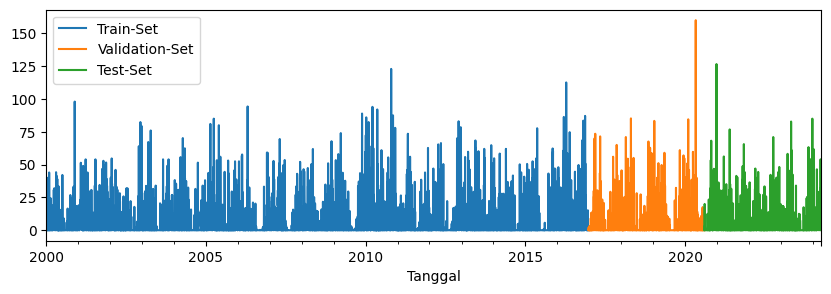

In [41]:
# Plot the train and test data after splitted
Bandung_rr.squeeze()[:train_size].plot.line(figsize=(10,3))
Bandung_rr.squeeze()[train_size:train_size + val_size].plot.line(figsize=(10,3))
Bandung_rr.squeeze()[train_size + val_size:].plot.line(figsize=(10,3))
plt.legend(['Train-Set', 'Validation-Set', 'Test-Set'])

## Feature Scaling

### Check Skewness

In [ ]:
def find_skewed_boundaries(df, variable, distance,skew):

    if ((skew>=0.5) | (skew<=-0.5)):

        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    else:
        lower_boundary=df[variable].mean() - (df[variable].std()*3)
        upper_boundary=df[variable].mean() + (df[variable].std()*3)

    return upper_boundary, lower_boundary

# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [ ]:
Bandung_rr=Bandung_rr.to_frame()

Rainfall
% Upper Outlier for quantity : 13.11%
% Lower Outlier for quantity : 0.00%
Skewness of quantity : 3.32


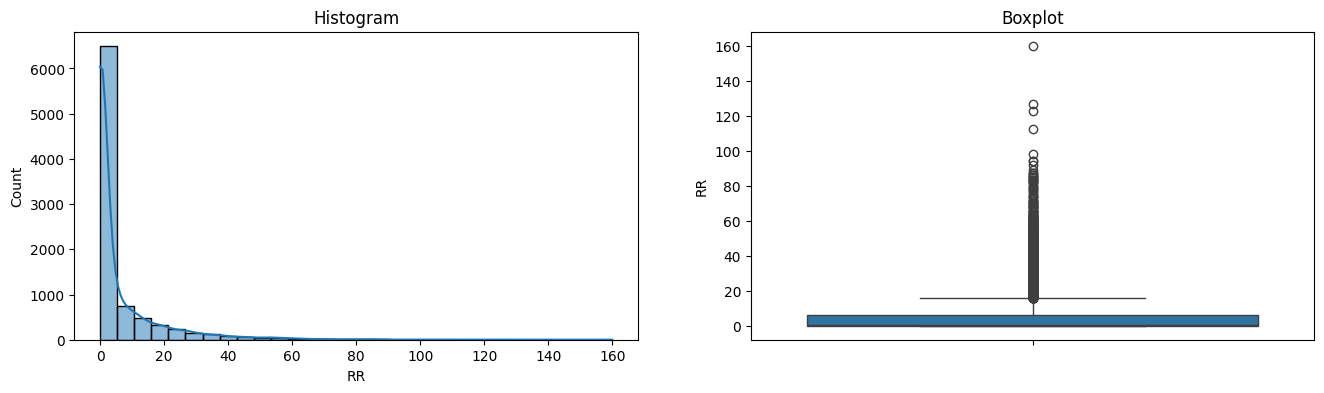

In [ ]:
# Check the outlier in the data

upper, lower=find_skewed_boundaries(Bandung_rr, 'RR', 1.5, Bandung_rr['RR'].skew())

out_u=(len(Bandung_rr[Bandung_rr['RR'] > upper])/len(Bandung_rr) * 100)
out_l=(len(Bandung_rr[Bandung_rr['RR'] < lower])/len(Bandung_rr) * 100)

print('Rainfall')
print('% Upper Outlier for quantity : {:.2f}%'.format(out_u))
print('% Lower Outlier for quantity : {:.2f}%'.format(out_l))
print('Skewness of quantity : {:.2f}'.format(Bandung_rr['RR'].skew()))
diagnostic_plots(Bandung_rr, 'RR')

### Feature Scaling

In [42]:
# Scaling the X data using MinMaxScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [43]:
X_train_scaled2 = X_train_scaled.reshape(-1, 1, 7)
X_val_scaled2  = X_val_scaled.reshape(-1, 1, 7)
X_test_scaled2 = X_test_scaled.reshape(-1, 1, 7)

y_train2 = y_train.reshape(-1, 1, 1)
y_val2 = y_val.reshape(-1, 1, 1)
y_test2 = y_test.reshape(-1, 1, 1)

'model = Sequential()\nmodel.add(LSTM(100, input_shape=(1, X_train_scaled2.shape[2]), return_sequences=True))\nmodel.add(LSTM(5, return_sequences=True))\nmodel.compile(loss="mean_absolute_error", optimizer="adam", metrics=[\'accuracy\'])\n\nhistory = model.fit(X_train_scaled2, y_train2, epochs=10, validation_data=(X_val_scaled2, y_val2))'

In [70]:
# Create datasets from tensor slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled2, y_train2))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled2, y_val2))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled2, y_test2))

# Shuffle and batch the datasets
batch_size = 70
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_scaled2)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Model Definition

LSTM Model


- input layer
- model sequential
- regularization
- optmizer
- batch size
- loss
- metrics




# Model Training

In [71]:
%%time
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(1, X_train_scaled2.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=True),
])

model.compile(loss="mean_absolute_error", optimizer="adam", metrics=['accuracy'])

# Model training
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
89/89 [==============================] - 6s 20ms/step - loss: 6.0875 - accuracy: 0.0110 - val_loss: 6.0041 - val_accuracy: 0.0000e+00
Epoch 2/10
89/89 [==============================] - 1s 7ms/step - loss: 6.0789 - accuracy: 0.0037 - val_loss: 5.9856 - val_accuracy: 0.0015
Epoch 3/10
89/89 [==============================] - 1s 8ms/step - loss: 6.0417 - accuracy: 0.0160 - val_loss: 5.9272 - val_accuracy: 0.0392
Epoch 4/10
89/89 [==============================] - 0s 4ms/step - loss: 5.9973 - accuracy: 0.0540 - val_loss: 5.8996 - val_accuracy: 0.1830
Epoch 5/10
89/89 [==============================] - 0s 5ms/step - loss: 5.9820 - accuracy: 0.0634 - val_loss: 5.8906 - val_accuracy: 0.0535
Epoch 6/10
89/89 [==============================] - 0s 4ms/step - loss: 5.9750 - accuracy: 0.0558 - val_loss: 5.8867 - val_accuracy: 0.0467
Epoch 7/10
89/89 [==============================] - 0s 5ms/step - loss: 5.9706 - accuracy: 0.0626 - val_loss: 5.8840 - val_accuracy: 0.0459
Epoch 8/10
89/8

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 8)              512       
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             1600      
                                                                 
Total params: 2112 (8.25 KB)
Trainable params: 2112 (8.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
%%time

# Model Training dengan menggunakan Dense Layer
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model2 = Sequential([
    Bidirectional(LSTM(32, return_sequences=True, kernel_initializer='HeNormal', recurrent_initializer='HeNormal',kernel_regularizer='l2', recurrent_regularizer='l2')),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.01),

    Bidirectional(LSTM(64, return_sequences=True,kernel_regularizer='l2')),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.01),

    Bidirectional(LSTM(128,kernel_regularizer='l2')),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.01),

    Dense(4,activation='softmax')

])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model2.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.RMSprop(),metrics='accuracy')

model_lstm_2 = model2.fit(train_dataset,
                         epochs=30,
                         callbacks=[callback],
                         validation_data=val_dataset)

Epoch 1/30
89/89 [==============================] - 18s 64ms/step - loss: 15.9071 - accuracy: 0.1308 - val_loss: 12.5382 - val_accuracy: 0.4571
Epoch 2/30
89/89 [==============================] - 3s 34ms/step - loss: 11.2503 - accuracy: 0.1317 - val_loss: 10.0194 - val_accuracy: 0.3366
Epoch 3/30
89/89 [==============================] - 2s 18ms/step - loss: 9.2969 - accuracy: 0.1257 - val_loss: 8.5053 - val_accuracy: 0.0060
Epoch 4/30
89/89 [==============================] - 2s 23ms/step - loss: 8.0781 - accuracy: 0.2144 - val_loss: 7.5599 - val_accuracy: 0.5000
Epoch 5/30
89/89 [==============================] - 2s 24ms/step - loss: 7.3258 - accuracy: 0.4916 - val_loss: 6.9789 - val_accuracy: 0.5000
Epoch 6/30
89/89 [==============================] - 2s 18ms/step - loss: 6.8626 - accuracy: 0.4916 - val_loss: 6.6175 - val_accuracy: 0.5000
Epoch 7/30
89/89 [==============================] - 3s 31ms/step - loss: 6.5690 - accuracy: 0.4916 - val_loss: 6.3816 - val_accuracy: 0.5000
Epoch 8/

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 8)              512       
                                                                 
 lstm_6 (LSTM)               (None, 1, 16)             1600      
                                                                 
Total params: 2112 (8.25 KB)
Trainable params: 2112 (8.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Evaluation

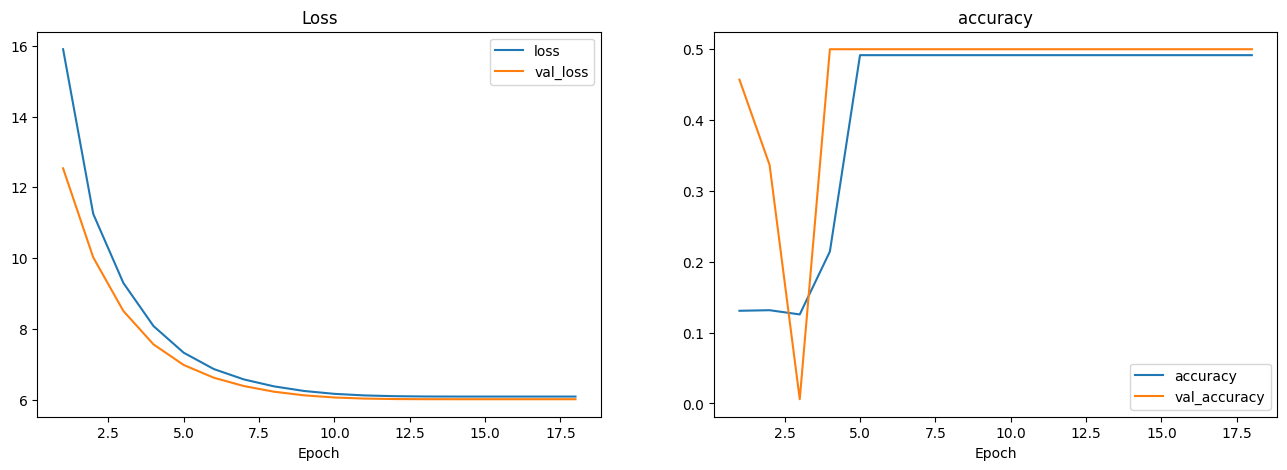

In [77]:
# Evaluation of the model

metrics2 = pd.DataFrame(model_lstm_2.history)

# Evaluate the loss and accuracy of the model
epoch=35

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,18+1),model_lstm_2.history['loss'],label='loss')
ax[0].plot(range(1,18+1),model_lstm_2.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,18+1),model_lstm_2.history['accuracy'],label='accuracy')
ax[1].plot(range(1,18+1),model_lstm_2.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()